### Research Question 4: Audience Preferences During Crises

In this question we will conduct the analysis by aligning global events such as wars, pandemics, and natural disasters to inspect both short-term and long-term shifts in audience preferences. To do this, we will inspect genre-specific trend analysis to identify immediate spikes in popularity as well as sustained changes over time. Later on, we will visualize the data to highlight both immediate and lasting impacts of global events on movie thematics.

In order to achieve this, we will utilize the Google Search Trends insights that will help us uncover user interest for both general movie genres and thematics and parcular movies in our aggregated movies dataset.

In [55]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from src.utils import google_trends as gt
from scipy.stats import pearsonr
import seaborn as sns
from src.utils import genres
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [2]:
# Import the movies data
movies = pd.read_table("data/movies_with_summaries.csv", sep=",")

In [3]:
movies.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
0,975900,tt0228333,Ghosts of Mars,Ghosts of Mars,2001-08-24,2001,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","['Action,Horror,Sci-Fi']",4.9,58872,14010832.0,98.0,['English Language'],['United States of America'],"Set in the second half of the 22nd century, th..."
1,261236,tt0083949,A Woman in Flames,Die flambierte Frau,1983,1983,['Drama'],['Drama'],5.9,648,NaN,106.0,['German Language'],['Germany'],"Eva, an upper class housewife, becomes frustra..."
2,171005,tt0097499,Henry V,Henry V,1989-11-08,1989,"['Costume drama', 'War film', 'Epic', 'Period ...","['Biography,Drama,History']",7.5,32088,10161099.0,137.0,['English Language'],['United Kingdom'],{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"['ChildrensFamily', 'Musical', 'Fantasy', 'Com...","['Comedy,Family,Fantasy']",7.8,189202,102272727.0,139.0,['English Language'],['United States of America'],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],['Drama'],7.7,24,NaN,108.0,['German Language'],['German Democratic Republic'],"Otto Brosowski, a communist miner, writes to t..."


In [4]:
# Get all genres
def get_top_genres(data, top_n=10):
    '''
    Get all time top movie genres based on IMDb genres
    '''
    # Format the genres
    data['Genres'] = data['Genres_IMDb'].str.strip("[]").str.replace("'", "").str.split(",")
    all_genres = data['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
    genres_count = Counter([genre.strip() for genres in all_genres for genre in genres])

    # Sort the genres by count
    genres = pd.DataFrame.from_dict(genres_count, orient='index').reset_index()
    genres.columns = ['Genre', 'Count']
    genres = genres.sort_values(by='Count', ascending=False)

    # Filter by the top n genres
    genres = genres.head(top_n)

    return genres

In [5]:
def format_keyword(genre):
    '''
    Format the search keyword for a given genre
    '''
    if "film" in genre.lower():
        keyword = genre
    else:
        keyword = genre + " movies"

    return keyword.lower()

#### 1. Inspecting overall audience preferences

In previous parts we have found the most prominent movies genres. We can check if the distribution of all movie genres reflects the viewer preferences of these same genres.

In [6]:
genres = get_top_genres(movies, 20)

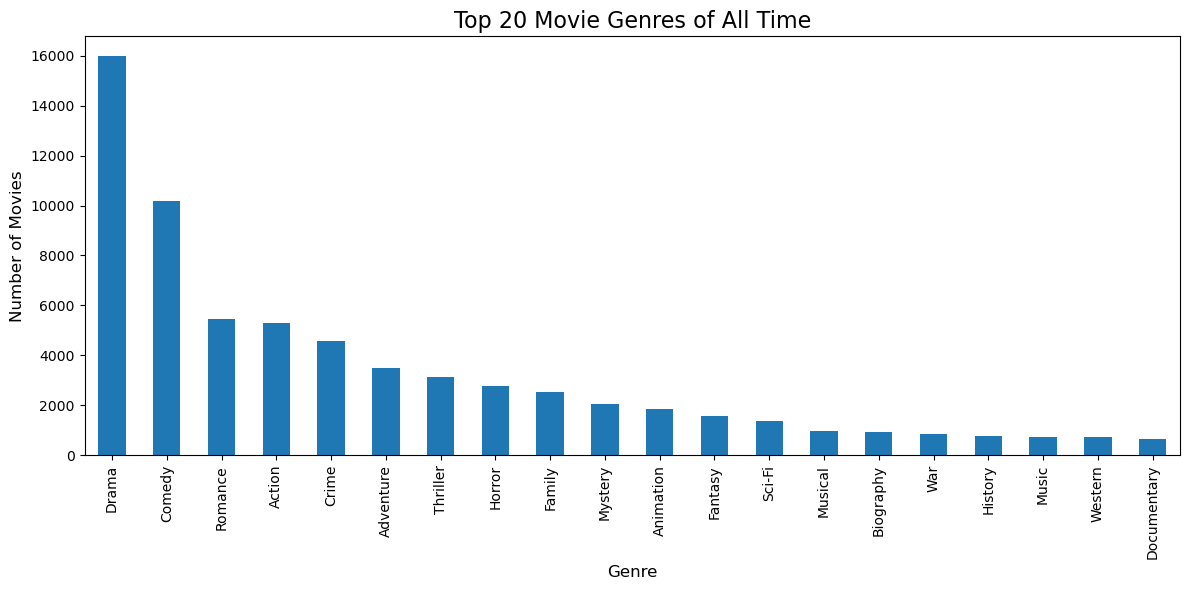

In [7]:
# Plot the distribution of genres
genres.plot(kind='bar', x='Genre', y='Count', legend=False, figsize=(12, 6))
plt.title('Top 20 Movie Genres of All Time', fontsize=16)
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We can now check if the popularity distribution of these genres is reflected in public preference. For this we can use the search trends that would help us understand the public preferences over a period of 2004-2012

In [8]:
# Define the genres to search for
genres['Keyword'] = genres['Genre'].apply(format_keyword)

In [9]:
# For each genre fetch the historical search interest
if pd.read_csv('data/genre_trends.csv').empty:
    trends = []
    for _, genre in genres.iterrows():
        print(f"Fetching historical search interest for: {genre['Keyword']}")
        trend = gt.query_full_interest(genre["Keyword"])
        trend["Genre"] = genre["Genre"]
        trends.append(trend)
    all_trends = pd.concat(trends)
    all_trends.to_csv('data/genre_trends.csv', index=False)
    

In [10]:
all_trends = pd.read_csv('data/genre_trends.csv')
all_trends['date'] = pd.to_datetime(all_trends['date'])

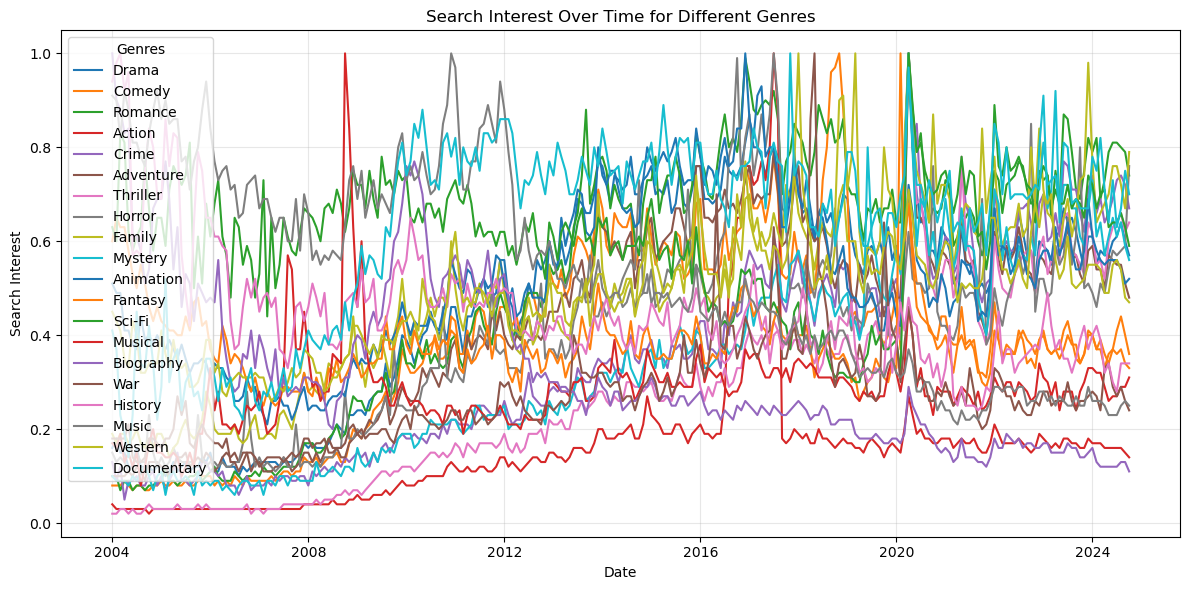

In [11]:
# Create the plot
plt.figure(figsize=(12, 6))
for genre in all_trends['Genre'].unique():
    genre_trend = all_trends[all_trends['Genre'] == genre]
    plt.plot(genre_trend['date'], genre_trend['value'], label=genre)

# Add labels and legend
plt.title('Search Interest Over Time for Different Genres')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend(title='Genres', loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The graph is unreadable! (Obviously) Let's try to untangle the trend with a more elegant visualization.

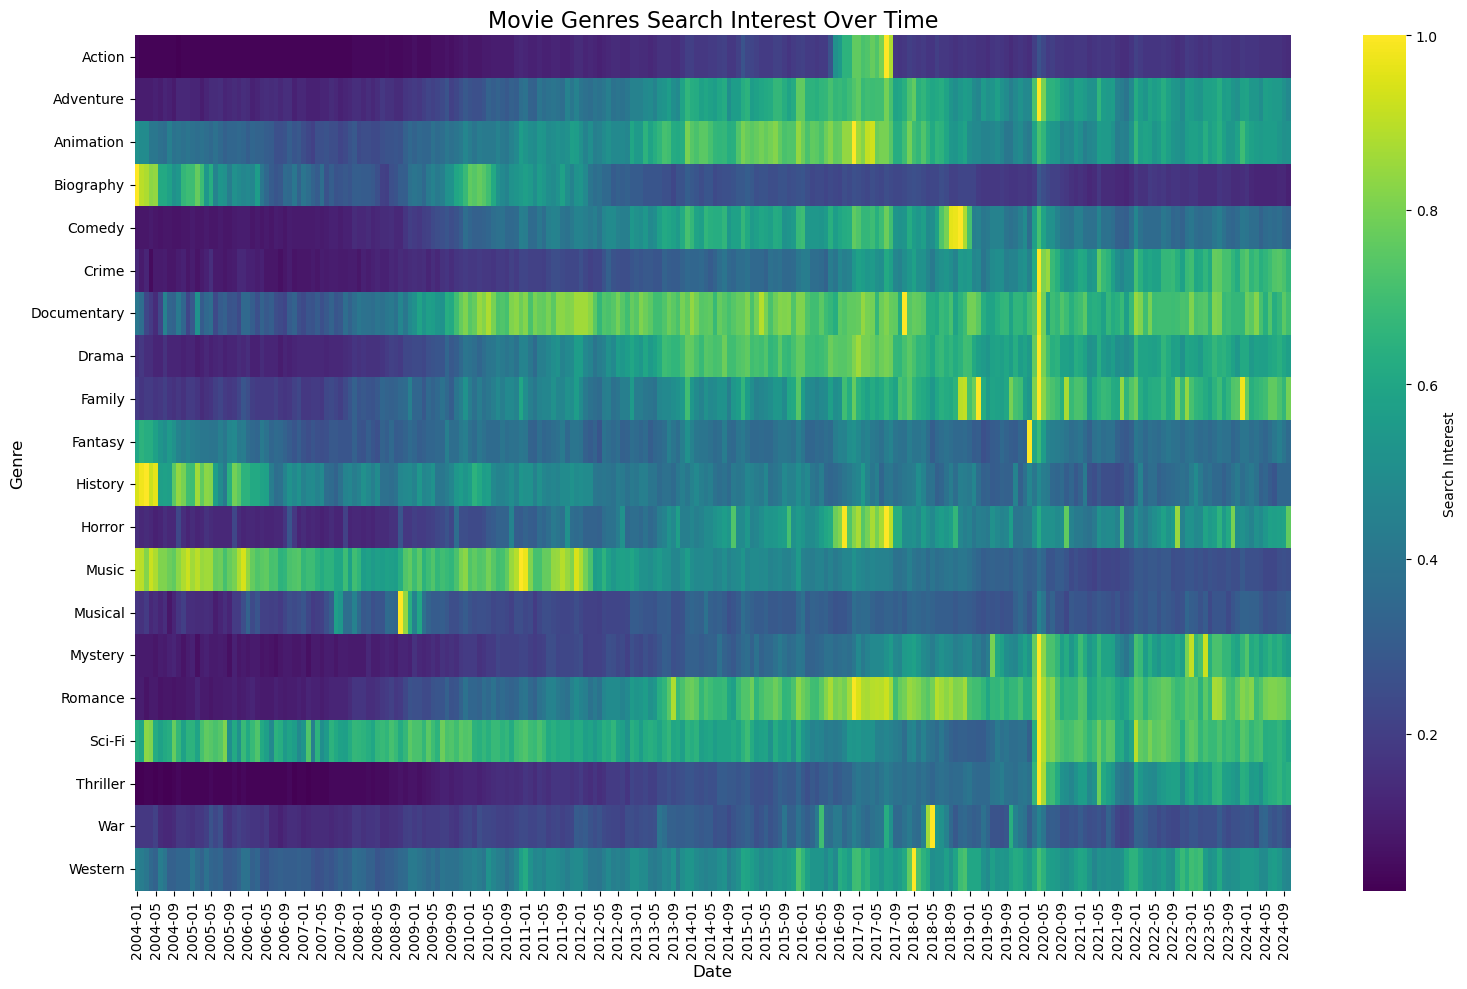

In [12]:
# Pivot the data to create a heatmap
heatmap_data = all_trends.pivot(index='Genre', columns='date', values='value')

# Format the date to show only year and month
heatmap_data.columns = heatmap_data.columns.strftime('%Y-%m')

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap='viridis', linewidths=0, cbar_kws={'label': 'Search Interest'})

# Add labels and title
plt.title('Movie Genres Search Interest Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Genre', fontsize=12)

# Rotate x-axis labels
plt.xticks(rotation=90, ha='center')

plt.tight_layout()
plt.show()

The first general observation is that the overall movies popularity peaked in 2016-2017 and then again in the beginning of COVID pandemics. The reason for the peak during the pandemics is clear - we were at stuck inside, what else could we do? However, why was there another peak in 2016-2017?

This peak could be explained by two of many other factors: 1) By 2015, streaming had firmly established itself as a dominant force in the entertainment industry. Netflix had expanded to over 190 countries, and Amazon Prime Video had also become a significant player, therefore driving interest in movies. 2) 2016-2017 were among the best years in history with the number of newly released movies as well as box office numbers peaked. Further analysis of such factors would be a particularly interesting idea but is worth another ADA project by itself.

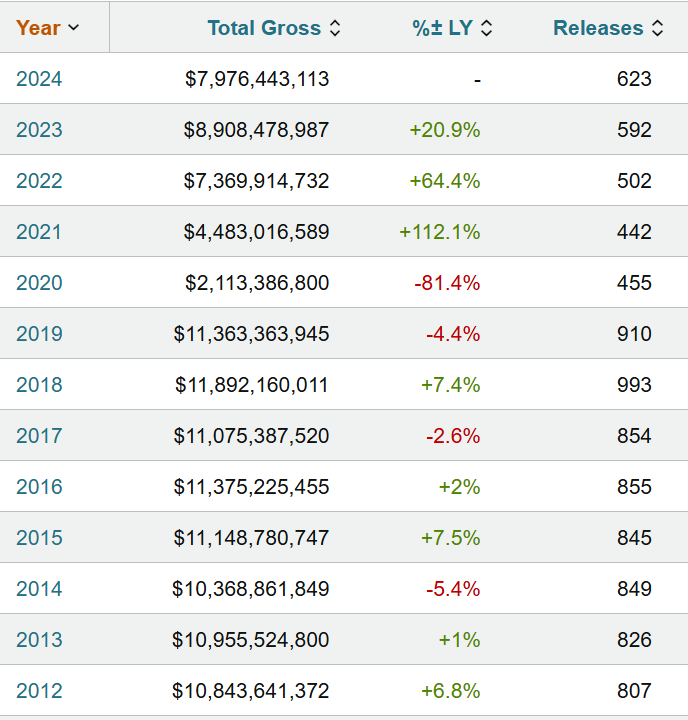

Source: [BoxOfficeMojo](https://www.boxofficemojo.com/year/)

If we zoom out, we can also observe strong seasonality patterns in particular movie genre interest. For example, interest for horror movies generally peaks during Halloween season and Family movies peak around Christmas. 

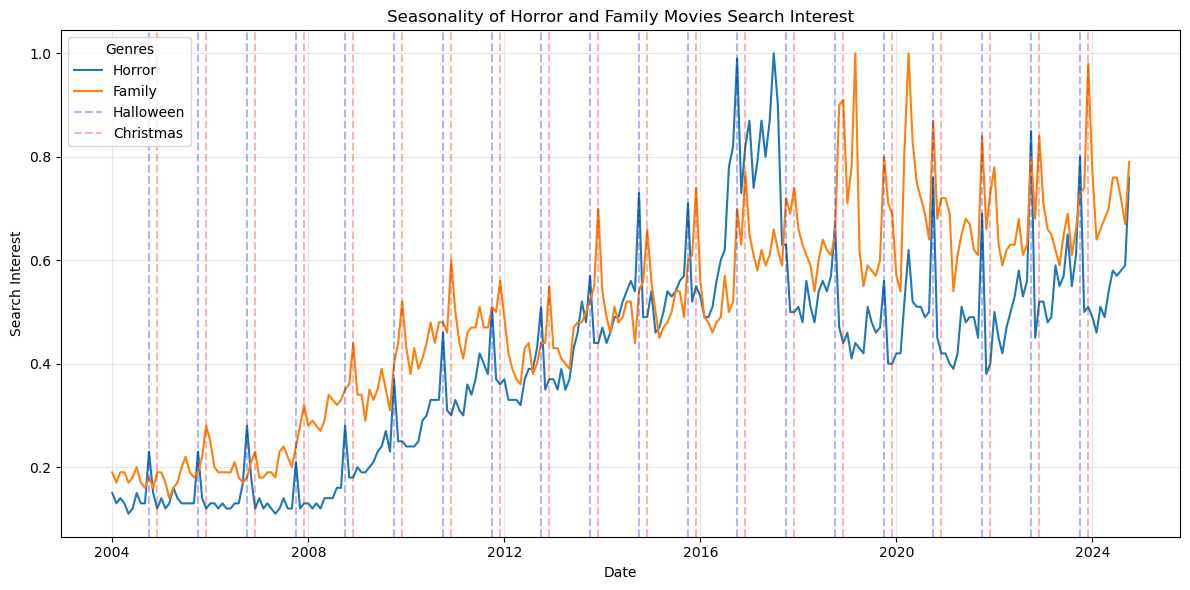

In [13]:
# Plot monthly interest for Horror, Family movies
horror = all_trends[all_trends['Genre'] == 'Horror']
family = all_trends[all_trends['Genre'] == 'Family']

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(horror['date'], horror['value'], label='Horror')
plt.plot(family['date'], family['value'], label='Family')

# Mark Every October and December with a vertical line
for year in range(2004, 2024):
    october = datetime.strptime(f"{year}-10", "%Y-%m")
    plt.axvline(october, color='blue', alpha=0.3, linestyle='--')
    december = datetime.strptime(f"{year}-12", "%Y-%m")
    plt.axvline(december, color='red', alpha=0.3, linestyle='--')

# Add vertical lines to legend
plt.plot([], [], color='blue', alpha=0.3, linestyle='--', label='Halloween')
plt.plot([], [], color='red', alpha=0.3, linestyle='--', label='Christmas')

plt.title('Seasonality of Horror and Family Movies Search Interest')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend(title='Genres')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

We can now perform a seasonal decomposition analysis to further inspect these patterns for all movie genres. This analysis is performed using an additive seasonality signal:

Y[t] = T[t] + S[t] + e[t]

- Y[t]: Popularity of a movie genre at time t
- T[t]: Trend
- S[t]: Seasonality
- e[t]: Residual (random noise)

This helps us to firstly identify if there are movie movie genres exhibiting strong seasonality patterns and secondly to identify the seasonality period for each genre. While we do not find more positive seasonality patterns as for Horror and Family movies, we can observe an more significant negative seasonality where historical movies popularity reduces during the summer months. One potential reason could be that historical movies are consumed for educational purposes, therefore during the summer months, when students are on vacation, the interest in historical movies decreases.

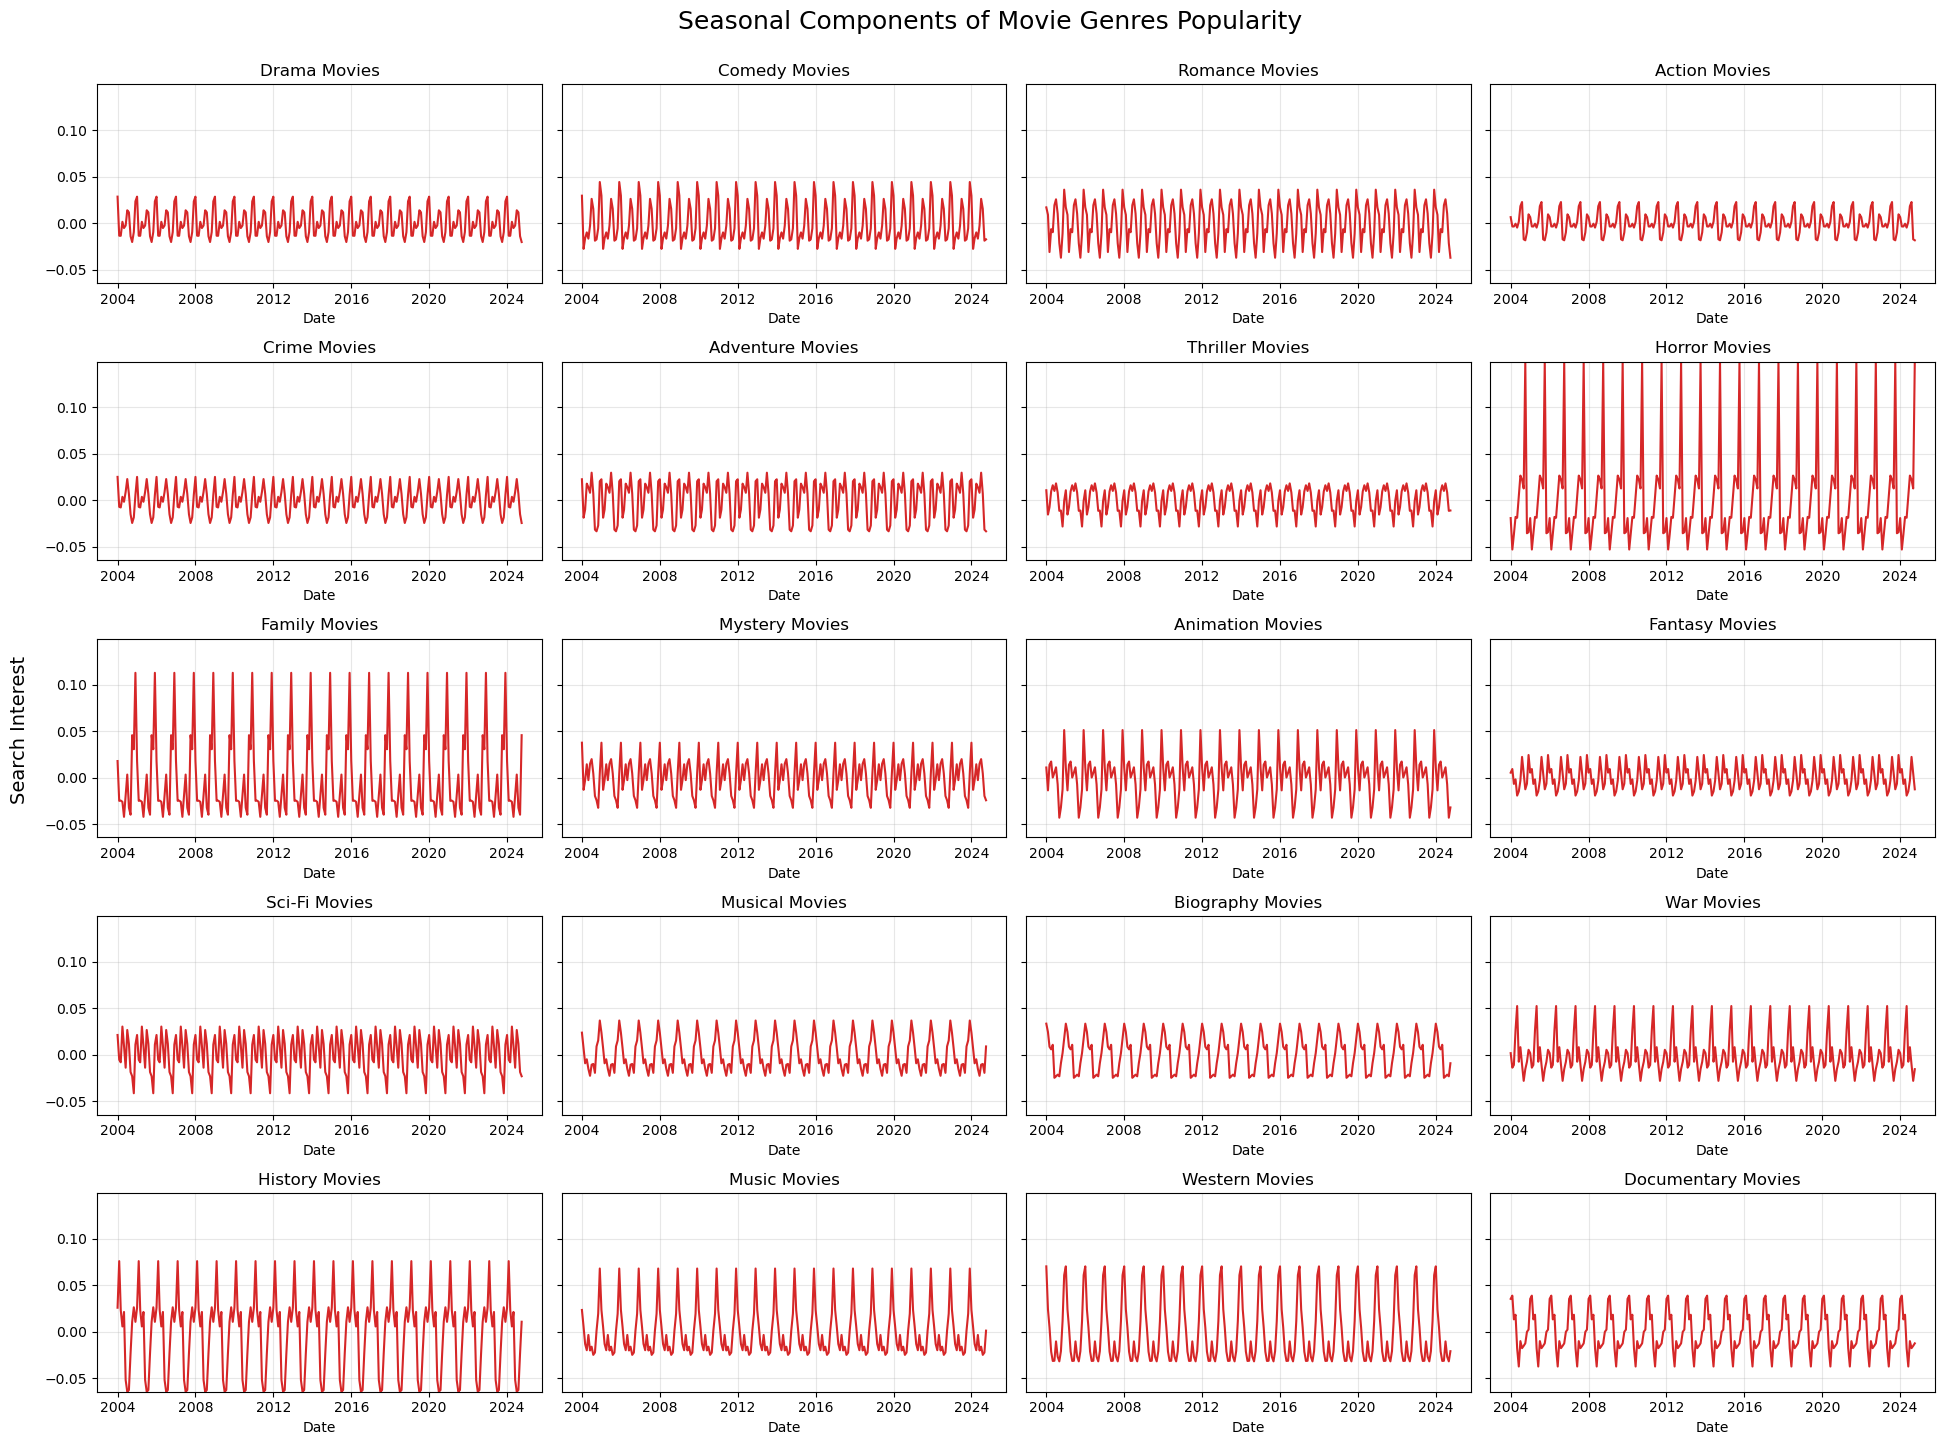

In [14]:
genres = all_trends['Genre'].unique()
genre_decompositions = {}

# Perform seasonal decomposition for each genre
for genre in genres:
    genre_data = all_trends[all_trends['Genre'] == genre].set_index('date')['value']
    
    # Apply seasonal decomposition
    decomposition = seasonal_decompose(genre_data, model='additive', period=12)
    genre_decompositions[genre] = decomposition

# Set up the subplots
fig, axes = plt.subplots(5, 4, figsize=(20, 15), sharey=True)
axes = axes.flatten()
y_min = min([decomposition.seasonal.min() for decomposition in genre_decompositions.values()])
y_max = max([decomposition.seasonal.max() for decomposition in genre_decompositions.values()])

# Plot each genre's seasonal component
for i, genre in enumerate(genres):
    decomposition = genre_decompositions[genre]
    axes[i].plot(decomposition.seasonal, label='Seasonality', color='tab:red')
    axes[i].set_title(f'{genre} Movies')
    axes[i].set_xlabel('Date')
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim(y_min, y_max)

# Set a common y axis label
fig.text(0.01, 0.5, 'Search Interest', va='center', rotation='vertical', fontsize=14)

# Adjust layout
fig.suptitle('Seasonal Components of Movie Genres Popularity', fontsize=18)
plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
plt.show()

This analysis also uncovers the trend for each genre. 

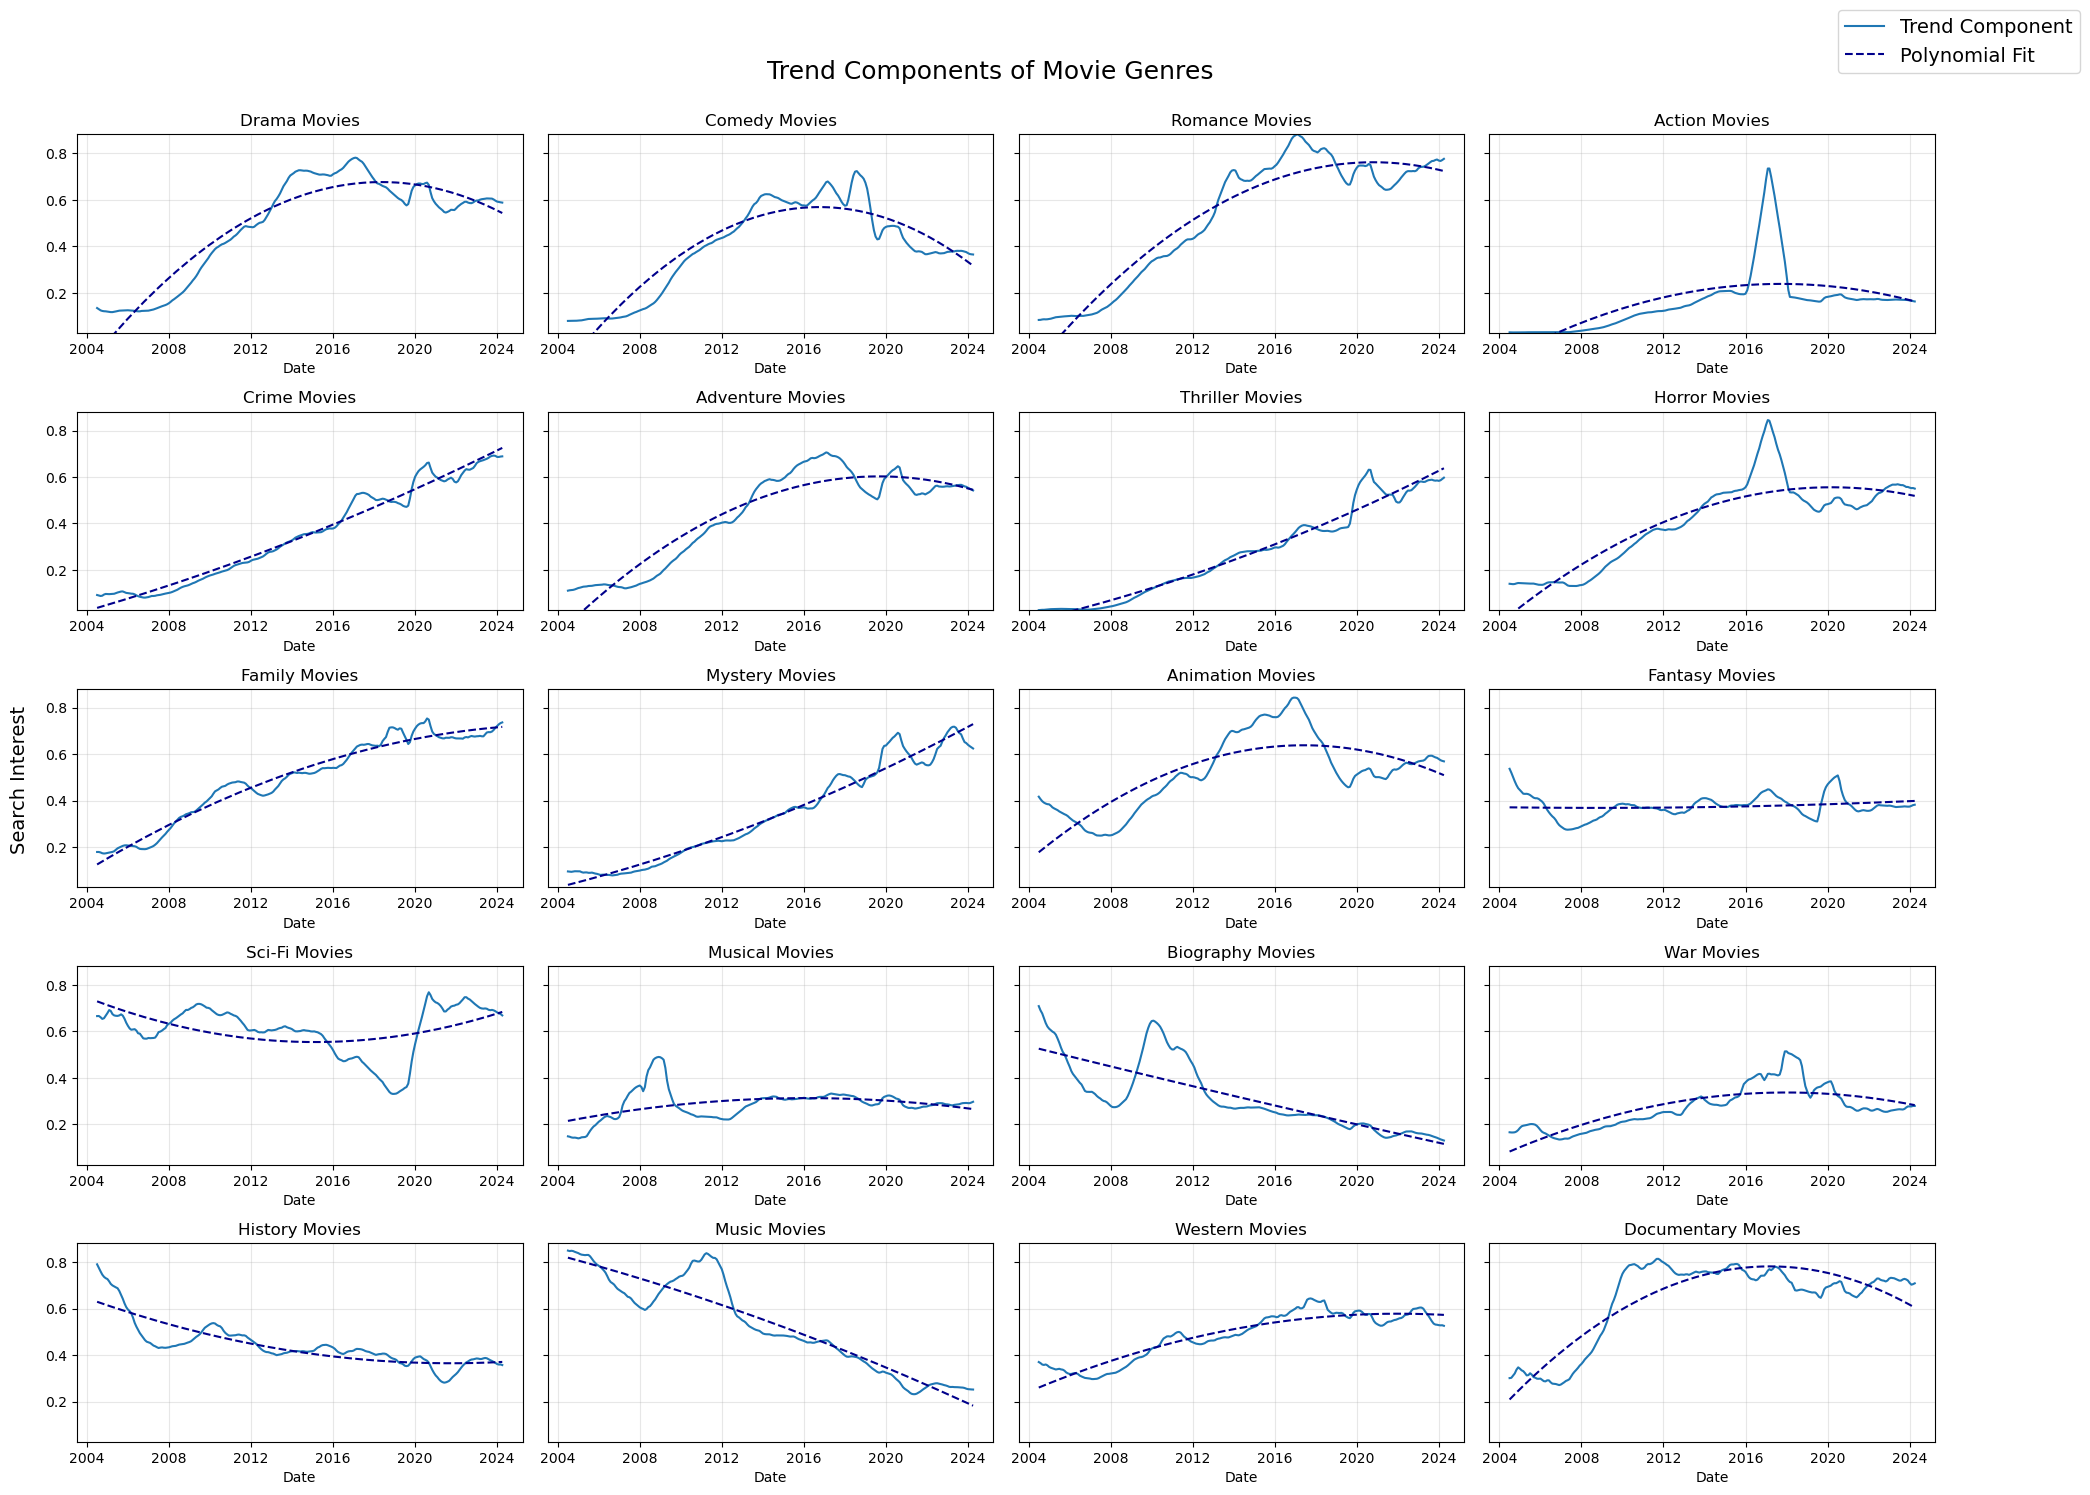

In [15]:
fig, axes = plt.subplots(5, 4, figsize=(20, 15), sharey=True)
axes = axes.flatten()

# Get a unified y-axis range for the trend component
y_min = min([decomposition.trend.min() for decomposition in genre_decompositions.values()])
y_max = max([decomposition.trend.max() for decomposition in genre_decompositions.values()])

# Plot each genre's trend component
for i, genre in enumerate(genres):
    decomposition = genre_decompositions[genre]
    trend = decomposition.trend.dropna()

    axes[i].set_title(f'{genre} Movies')
    axes[i].set_xlabel('Date')
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim(y_min, y_max)

    x = trend.index.map(lambda date: date.toordinal())
    y = trend.values

    # Fit a polynomial regression of degree 2
    coefficients = np.polyfit(x, y, deg=2)
    polynomial = np.poly1d(coefficients)

    # Generate fitted values for the polynomial line
    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = polynomial(x_fit)

    # Plot the trend component
    axes[i].plot(trend.index, y, label='Trend', color='tab:blue')

    # Plot the polynomial regression line
    axes[i].plot([pd.Timestamp.fromordinal(int(val)) for val in x_fit], y_fit, color='darkblue', linestyle='--')
    
# Set a common y axis label
fig.text(0.01, 0.5, 'Search Interest', va='center', rotation='vertical', fontsize=14)

# Adjust layout
fig.suptitle('Trend Components of Movie Genres', fontsize=18)
plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])

# Plot a large legend outside of the subplots
handles = [plt.Line2D([0], [0], color='tab:blue', label='Trend Component'),
           plt.Line2D([0], [0], color='darkblue', linestyle='--', label='Polynomial Fit',)]
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.05, 1.02), fontsize=14, frameon=True)
plt.show()

Taking all these considerations into account, we can nonetheless observe clear shifts in popularity of certain genres. Are these fluctuations related to the number of movies released during the years? To answer this, we will have to restrict ourselves in movies data availability period which overlaps with available Google Search Trends Data for years 2004-2012.

In [16]:
# Filter movies dataset for the period 2004-2012
movies_filtered = movies[(movies['Year'] >= 2004)]
movies_filtered = movies_filtered.explode('Genres')
movies_filtered.rename(columns={'Genres': 'Genre'}, inplace=True)
movies_filtered.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genre,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
5,21926710,tt0892904,White on Rice,White on Rice,2009,2009,Comedy,['Comedy'],6.1,552,NaN,82.0,[],['United States of America'],Jimmy ([[Hiroshi Watanabe loves dinosaurs and...
14,12008535,tt0405393,Rudo y Cursi,Rudo y Cursi,2008,2008,Comedy,"['Comedy,Drama,Sport']",6.7,9419,11091868.0,103.0,['Spanish Language'],"['Mexico', 'United States of America']","In the fictional farming village of Tlachtlán,..."
14,12008535,tt0405393,Rudo y Cursi,Rudo y Cursi,2008,2008,Drama,"['Comedy,Drama,Sport']",6.7,9419,11091868.0,103.0,['Spanish Language'],"['Mexico', 'United States of America']","In the fictional farming village of Tlachtlán,..."
14,12008535,tt0405393,Rudo y Cursi,Rudo y Cursi,2008,2008,Sport,"['Comedy,Drama,Sport']",6.7,9419,11091868.0,103.0,['Spanish Language'],"['Mexico', 'United States of America']","In the fictional farming village of Tlachtlán,..."
19,12371532,tt0479879,Chasing Ghosts: Beyond the Arcade,Chasing Ghosts: Beyond the Arcade,2007,2007,Documentary,['Documentary'],7.0,1449,NaN,90.0,['English Language'],['United States of America'],"In the 1980s, video games were synonymous with..."


In [17]:
# Count the number of movies released per top genres per year
genre_counts = movies_filtered.groupby(['Year', 'Genre']).size().reset_index()
genre_counts.columns = ['Year', 'Genre', 'Count']
genre_counts.head()

,Year,Genre,Count
0,2004,Action,199
1,2004,Adult,1
2,2004,Adventure,97
3,2004,Animation,39
4,2004,Biography,27


In [18]:
# Filter only the top genres
genre_counts = genre_counts[genre_counts['Genre'].isin(genres)]
genre_counts.head()

,Year,Genre,Count
0,2004,Action,199
2,2004,Adventure,97
3,2004,Animation,39
4,2004,Biography,27
5,2004,Comedy,291


In [19]:
# Filter trends for the period 2004-2012
trends_filtered = all_trends[(all_trends['date'] >= '2004-01-01') & (all_trends['date'] <= '2012-12-31')]

# Group the trends by year and genre
trends_filtered['Year'] = trends_filtered['date'].dt.year
trends_grouped = trends_filtered.groupby(['Year', 'Genre'])['value'].mean().reset_index()

C:\Users\aidas\AppData\Local\Temp\ipykernel_31244\3375120179.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trends_filtered['Year'] = trends_filtered['date'].dt.year


In [20]:
# Merge movie counts with search interest data
merged_data = pd.merge(genre_counts, trends_grouped, on=['Year', 'Genre'], how='inner')

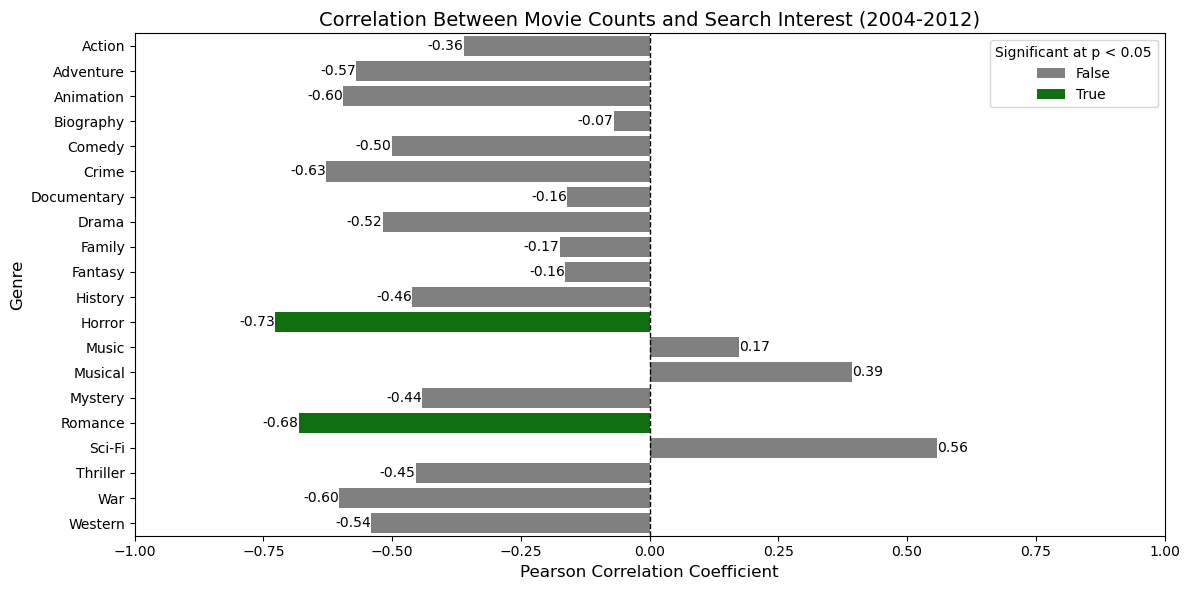

In [21]:
# Compute pearson correlation and p-value
results = []
for genre in merged_data['Genre'].unique():
    genre_data = merged_data[merged_data['Genre'] == genre]
    corr, p_value = pearsonr(genre_data['Count'], genre_data['value'])
    results.append({'Genre': genre, 'Correlation': corr, 'P-Value': p_value})

# Create a results DataFrame
results_df = pd.DataFrame(results)

# Visualize the correlations
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df.sort_values('Correlation', ascending=False),
    x='Correlation',
    y='Genre',
    hue=(results_df['P-Value'] < 0.05),
    dodge=False,
    palette={True: 'green', False: 'gray'}
)

# Show the correlation values
for i, row in results_df.iterrows():
    plt.text(row['Correlation'], i, f"{row['Correlation']:.2f}", va='center', ha= 'right' if row['Correlation'] < 0 else 'left')

# Set the x-axis limits
plt.xlim(-1, 1)

# Add labels and title
plt.title('Correlation Between Movie Counts and Search Interest (2004-2012)', fontsize=14)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend(title='Significant at p < 0.05')
plt.tight_layout()
plt.show()

The results suggest that the number of genre-specific movies released in a year is largely negatively correlated with the interest for such a genre. A possible explanation for that could be that if more movies are released in a genre, audiences might experience fatigue or feel overwhelmed, leading to a decline in search interest. Nonetheless, there are three notable outliers over our defined sample period: Music, Musicals and Sci-Fi movies. These differences could be explained by a particular boom of Sci-Fi movies released over the 2000s. A shorter boom in Musicals, especially notable with the release of *Mamma Mia!* and other Musicals that followed the influx of this movie's genres. Nonetheless, these results are not significant at a 5% confidence level, therefore cannot be considered as a strong evidence of a relationship between the number of movies released and the interest in a genre.

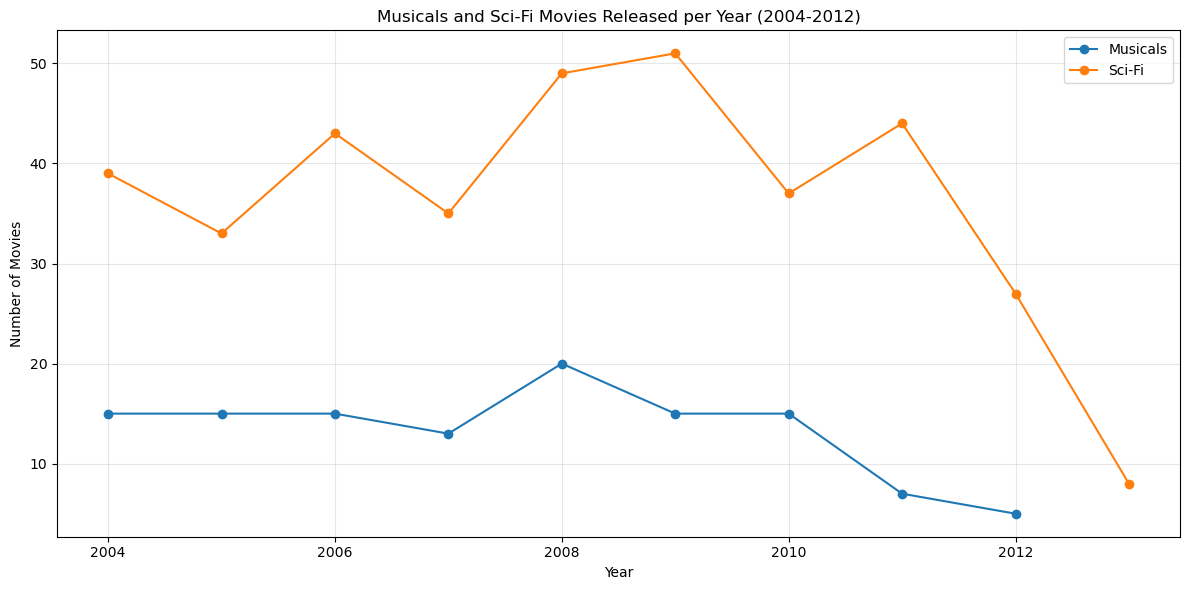

In [22]:
# Plot the number of musicals and sci-fi movies per year
musicals = movies_filtered[movies_filtered['Genre'] == 'Musical']
musicals = musicals.groupby('Year').size().reset_index()
musicals.columns = ['Year', 'Count']

scifi = movies_filtered[movies_filtered['Genre'] == 'Sci-Fi']
scifi = scifi.groupby('Year').size().reset_index()
scifi.columns = ['Year', 'Count']

plt.figure(figsize=(12, 6))
plt.plot(musicals['Year'], musicals['Count'], marker='o')
plt.plot(scifi['Year'], scifi['Count'], marker='o')
plt.title('Musicals and Sci-Fi Movies Released per Year (2004-2012)')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.legend(['Musicals', 'Sci-Fi'])
plt.grid(alpha=0.3)
plt.tight_layout()

But what about the impact of global events on audience preferences? To answer this question, we will shift focus to changes in genre popularity when these events occur. We can firstly try to check if certain events that happen impact the interest of certain movie genres. 

In [97]:
# Fetch events dataset
events = pd.read_csv("data/events.csv")
events.head()

,date,description,event_type
0,1902-05-31,Second Boer War ends in British victory.,war
1,1903-06-11,King Alexander I of Serbia and his wife Queen ...,political instability
2,1904-02-08,A Japanese surprise attack on Port Arthur (Lus...,war
3,1905-01-22,The Revolution of 1905 in Russia erupts.,political instability
4,1905-03-31,"The First Moroccan Crisis begins, going until ...",catastrophe


In [98]:
# Filter events for the period 2004-2012
events['date'] = pd.to_datetime(events['date'])
events_filtered = events[(events['date'] >= '2004-01-01') & (events['date'] <= '2012-12-31')]
events_filtered['Month'] = events_filtered['date'].dt.to_period('M')

C:\Users\aidas\AppData\Local\Temp\ipykernel_31244\451031233.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_filtered['Month'] = events_filtered['date'].dt.to_period('M')


In [99]:
# Count events per year and type
events_grouped = events_filtered.groupby(['Month', 'event_type']).size().reset_index()
events_grouped.columns = ['Month', 'event_type', 'Count']

In [100]:
event_types = events_grouped['event_type'].unique()

In [101]:
all_trends = pd.read_csv('data/genre_trends.csv')
trends_filtered = trends_filtered[(all_trends['date'] >= '2004-01-01') & (all_trends['date'] <= '2012-12-31')]
trends_filtered['date'] = pd.to_datetime(trends_filtered['date'])

C:\Users\aidas\AppData\Local\Temp\ipykernel_31244\2357381164.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trends_filtered = trends_filtered[(all_trends['date'] >= '2004-01-01') & (all_trends['date'] <= '2012-12-31')]


In [102]:
trends_filtered['Month'] = trends_filtered['date'].dt.to_period('M')
trends_filtered

,date,value,keyword,Genre,Year,YearMonth,Month
0,2004-01-01,0.16,drama movies,Drama,2004,2004-01,2004-01
1,2004-02-01,0.18,drama movies,Drama,2004,2004-02,2004-02
2,2004-03-01,0.15,drama movies,Drama,2004,2004-03,2004-03
3,2004-04-01,0.15,drama movies,Drama,2004,2004-04,2004-04
4,2004-05-01,0.12,drama movies,Drama,2004,2004-05,2004-05
...,...,...,...,...,...,...,...
4853,2012-08-01,0.74,documentary movies,Documentary,2012,2012-08,2012-08
4854,2012-09-01,0.79,documentary movies,Documentary,2012,2012-09,2012-09
4855,2012-10-01,0.74,documentary movies,Documentary,2012,2012-10,2012-10
4856,2012-11-01,0.70,documentary movies,Documentary,2012,2012-11,2012-11


In [103]:
trends_grouped = trends_filtered.groupby(['Month', 'Genre'])['value'].mean().reset_index()

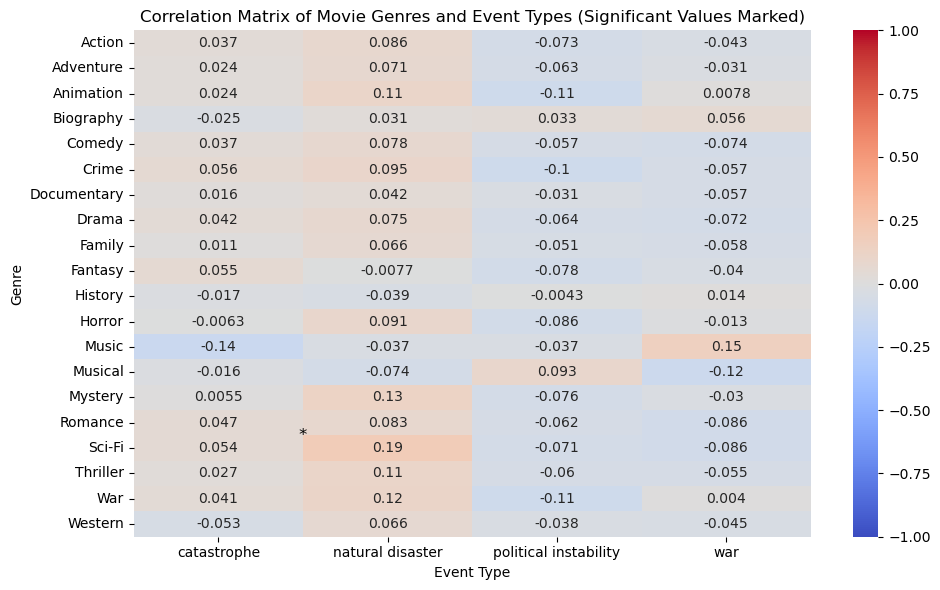

In [104]:
correlations = []

# Iterate over each combination of genre and event type
for genre in genres:
    # Select movie genre search interest data
    trends_grouped_genre = trends_grouped[trends_grouped['Genre'] == genre]
    
    for event_type in event_types:
        # Select events for the current event type
        events_by_type = events_grouped[events_grouped['event_type'] == event_type]
        
        # Merge the events with search interest data
        merged_data = pd.merge(events_by_type, trends_grouped_genre, on='Month', how='outer').fillna(0)
        
        # Calculate the yearly total number of events for this event type
        yearly_event_count = merged_data.groupby('Month')['Count'].sum()
        
        # Calculate the search interest for the current genre
        yearly_search_interest = merged_data.groupby('Month')['value'].sum()
        
        # Compute Pearson correlation
        corr, p_value = pearsonr(yearly_event_count, yearly_search_interest)
        
        # Append the result to the correlations list
        correlations.append([event_type, genre, corr, p_value])

# Convert the list of correlations into a DataFrame
correlation_df = pd.DataFrame(correlations, columns=['Event Type', 'Genre', 'Pearson Correlation', 'P-Value'])

# Pivot the DataFrame to create a correlation matrix (using keyword arguments)
correlation_matrix = correlation_df.pivot(index='Genre', columns='Event Type', values='Pearson Correlation')

# Create a mask for significant correlations (p-value < 0.05)
significance_mask = correlation_df['P-Value'] < 0.05

# Filter correlations that are statistically significant
significant_correlations = correlation_df[significance_mask]

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Mark statistically significant correlations with asterisks
for _, row in significant_correlations.iterrows():
    event_type = row['Event Type']
    genre = row['Genre']
    corr_value = row['Pearson Correlation']
    
    # Add an asterisk next to the correlation value in the matrix
    plt.text(correlation_matrix.columns.get_loc(event_type), 
             correlation_matrix.index.get_loc(genre),
             '*', 
             ha='center', 
             va='center', 
             fontsize=12, 
             color='black')

plt.title('Correlation Matrix of Movie Genres and Event Types (Significant Values Marked)')
plt.tight_layout()
plt.show()

Unfortunately, it is hard to distinguish any significant monhtly impacts of these events on the genreal interest of movie genres. The only correlation that appears to be significant at a 5% CI level is the impact of natural disasters on the interest in Sci-Fi movies. Domain knowledge could help us to explain this correlation. For example, natural disasters could lead to a fear, therefore increasing the interest in particular subtype of Sci-Fi movies that feature those natural disasters. Nonetheless, this is a weak correlation and should be taken with caution. There is also no shift in sentiment toward postive or negative genres during these events.

C:\Users\aidas\AppData\Local\Temp\ipykernel_31244\1884510741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_filtered['YearMonth'] = events_filtered['date'].dt.to_period('M')


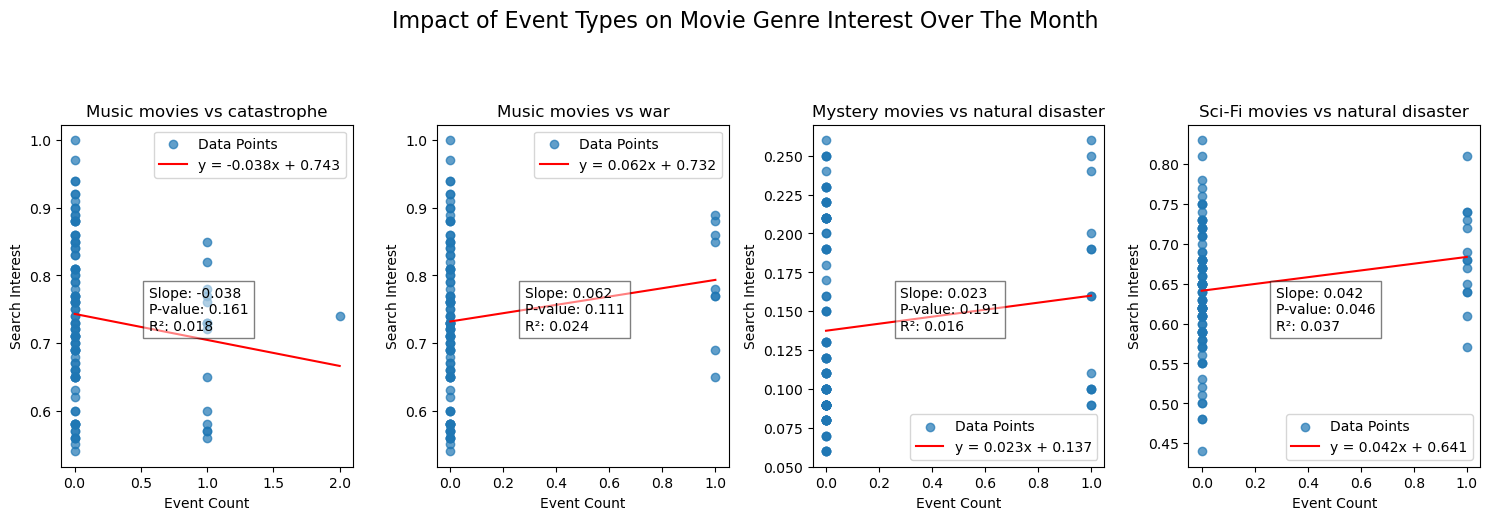

In [114]:
# Group events and trends monthly
events_filtered['YearMonth'] = events_filtered['date'].dt.to_period('M')
trends_filtered['YearMonth'] = trends_filtered['date'].dt.to_period('M')

# Aggregate counts of events by type per month
events_monthly = events_filtered.groupby(['YearMonth', 'event_type']).size().reset_index(name='event_count')

# Aggregate search interest by genre per month
trends_monthly = trends_filtered.groupby(['YearMonth', 'Genre'])['value'].sum().reset_index()

# Unique genres and event types
genres = trends_monthly['Genre'].unique()
event_types = events_monthly['event_type'].unique()

# Prepare to collect regression results for plotting
regression_results = []

# Set up the plot grid
num_genres = len(genres)
num_event_types = len(event_types)
fig, axes = plt.subplots(num_genres, num_event_types, figsize=(15, num_genres * 4), sharex=False, sharey=False)
axes = axes.flatten()

plot_index = 0
for genre in genres:
    genre_data = trends_monthly[trends_monthly['Genre'] == genre]
    
    for event_type in event_types:
        # Event type data
        event_data = events_monthly[events_monthly['event_type'] == event_type]
        
        # Merge monthly data
        merged_data = pd.merge(genre_data, event_data, on='YearMonth', how='outer').fillna(0)
        
        # Regression Analysis
        X = merged_data['event_count']
        y = merged_data['value']
        X_with_const = sm.add_constant(X)
        
        model = sm.OLS(y, X_with_const).fit()
        slope = model.params['event_count']
        p_value = model.pvalues['event_count']
        r_squared = model.rsquared
        
        # Store results for further analysis
        regression_results.append([event_type, genre, slope, p_value, r_squared])

        # Only plot more significant correlations
        if p_value > 0.2:
            continue
        
        # Scatterplot with regression line
        ax = axes[plot_index]
        ax.scatter(X, y, alpha=0.7, label='Data Points')
        
        # Plot regression line
        line_x = np.linspace(X.min(), X.max(), 100)
        line_y = slope * line_x + model.params['const']
        ax.plot(line_x, line_y, color='red', label=f"y = {slope:.3f}x + {model.params['const']:.3f}")
        
        # Display statistics
        ax.text(0.3, 0.4, f"Slope: {slope:.3f}\nP-value: {p_value:.3f}\nR²: {r_squared:.3f}",
                transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        
        ax.set_title(f"{genre} movies vs {event_type}")
        ax.set_xlabel("Event Count")
        ax.set_ylabel("Search Interest")
        ax.legend()
        
        plot_index += 1

# Remove empty subplots
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

# Finalize plot
plt.tight_layout()
plt.suptitle("Impact of Event Types on Movie Genre Interest Over The Month", y=1.01, fontsize=16)
plt.show()

# Convert regression results to DataFrame
regression_df = pd.DataFrame(regression_results, columns=['Event Type', 'Genre', 'Slope', 'P-Value', 'R-Squared'])

After appyling causal analysis, we find that natural disasters are indeed impacting the interest on Sci-fi movies positively at around 4.2%. Nonetheless, while this result is once again significant at the 5% CI level, the low R^2 value seems to indicate that the variance of this not well explained. Once again, the interest of movie genres is not significantly impacted by global events. This could be due to the fact that movies are a form of escapism.

Firstly, in face of starting wars, can we observe a short term impact on audience preferences? To answer this question, we will inspect the popularity of war and historical movies around the period when wars started.

In [28]:
events = pd.read_csv("data/events.csv")
events.head()

,date,description,event_type
0,1902-05-31,Second Boer War ends in British victory.,war
1,1903-06-11,King Alexander I of Serbia and his wife Queen ...,political instability
2,1904-02-08,A Japanese surprise attack on Port Arthur (Lus...,war
3,1905-01-22,The Revolution of 1905 in Russia erupts.,political instability
4,1905-03-31,"The First Moroccan Crisis begins, going until ...",catastrophe


In [29]:
# Filter all wars for the period 2004-2012
wars = events[events['event_type'] == 'war']
wars_filtered = wars[(wars['date'] >= '2004-01-01') & (wars['date'] <= '2012-12-31')]
wars_filtered

,date,description,event_type
391,2004-11-07,The Second Battle of Fallujah occurs. It is th...,war
393,2005-01-09,Second Sudanese Civil War ends.,war
397,2005-07-28,The Provisional Irish Republican Army ends its...,war
402,2006-02-22,2006 al-Askari mosque bombing turns the escala...,war
406,2007-03-04,First Ivorian Civil War ends.,war
408,2007-06-10,Fatah-Hamas conflict : The Battle of Gaza (200...,war
423,2010-11-23,North Korea shells the island of Yeonpyeong .,war
426,2011-05-02,Osama bin Laden is shot dead by United States ...,war
429,2011-10-20,Muammar Gaddafi is captured and killed during ...,war


Fetching for: The Second Battle of Fallujah occurs. It is the deadliest American battle since the Vietnam War , killing 95 troops.
[{'time': 'Oct 28, 2004', 'value': 42}, {'time': 'Oct 29, 2004', 'value': 0}, {'time': 'Oct 30, 2004', 'value': 0}, {'time': 'Oct 31, 2004', 'value': 57}, {'time': 'Nov 1, 2004', 'value': 57}, {'time': 'Nov 2, 2004', 'value': 0}, {'time': 'Nov 3, 2004', 'value': 0}, {'time': 'Nov 4, 2004', 'value': 0}, {'time': 'Nov 5, 2004', 'value': 41}, {'time': 'Nov 6, 2004', 'value': 0}, {'time': 'Nov 7, 2004', 'value': 69}, {'time': 'Nov 8, 2004', 'value': 0}, {'time': 'Nov 9, 2004', 'value': 0}, {'time': 'Nov 10, 2004', 'value': 0}, {'time': 'Nov 11, 2004', 'value': 71}, {'time': 'Nov 12, 2004', 'value': 79}, {'time': 'Nov 13, 2004', 'value': 56}, {'time': 'Nov 14, 2004', 'value': 100}, {'time': 'Nov 15, 2004', 'value': 57}, {'time': 'Nov 16, 2004', 'value': 34}, {'time': 'Nov 17, 2004', 'value': 51}]
           time  value
0  Oct 28, 2004     42
1  Oct 29, 2004     

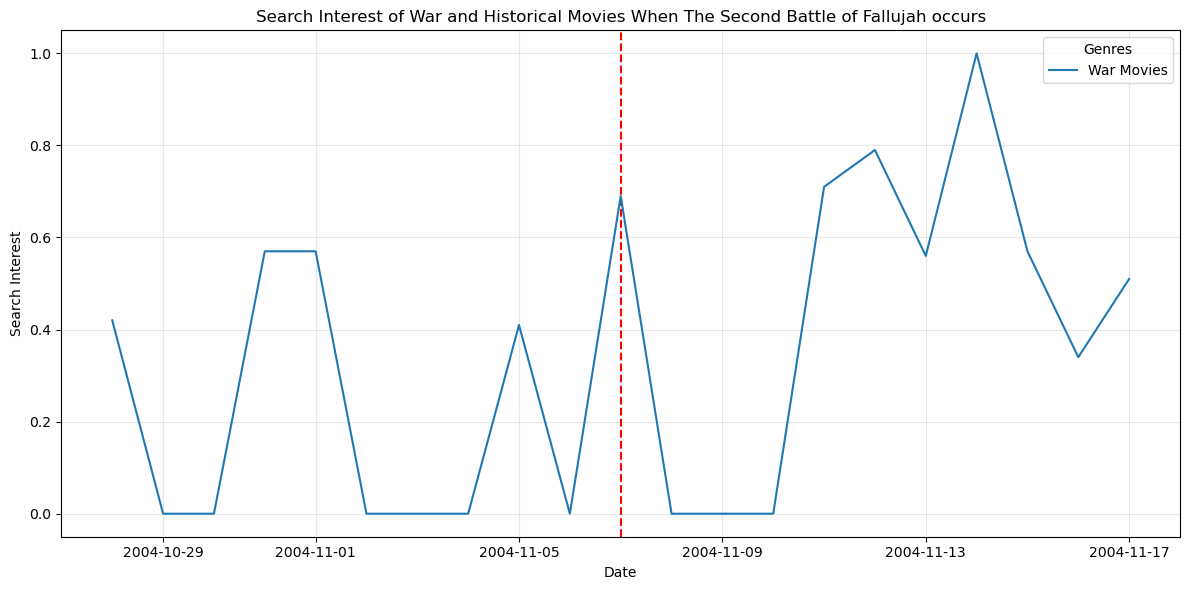

Fetching for: Second Sudanese Civil War ends.
[{'time': 'Dec 30, 2004', 'value': 85}, {'time': 'Dec 31, 2004', 'value': 0}, {'time': 'Jan 1, 2005', 'value': 0}, {'time': 'Jan 2, 2005', 'value': 0}, {'time': 'Jan 3, 2005', 'value': 100}, {'time': 'Jan 4, 2005', 'value': 61}, {'time': 'Jan 5, 2005', 'value': 49}, {'time': 'Jan 6, 2005', 'value': 0}, {'time': 'Jan 7, 2005', 'value': 0}, {'time': 'Jan 8, 2005', 'value': 96}, {'time': 'Jan 9, 2005', 'value': 76}, {'time': 'Jan 10, 2005', 'value': 56}, {'time': 'Jan 11, 2005', 'value': 78}, {'time': 'Jan 12, 2005', 'value': 64}, {'time': 'Jan 13, 2005', 'value': 57}, {'time': 'Jan 14, 2005', 'value': 59}, {'time': 'Jan 15, 2005', 'value': 0}, {'time': 'Jan 16, 2005', 'value': 0}, {'time': 'Jan 17, 2005', 'value': 76}, {'time': 'Jan 18, 2005', 'value': 0}, {'time': 'Jan 19, 2005', 'value': 0}]
           time  value
0  Dec 30, 2004     85
1  Dec 31, 2004      0
2   Jan 1, 2005      0
3   Jan 2, 2005      0
4   Jan 3, 2005    100


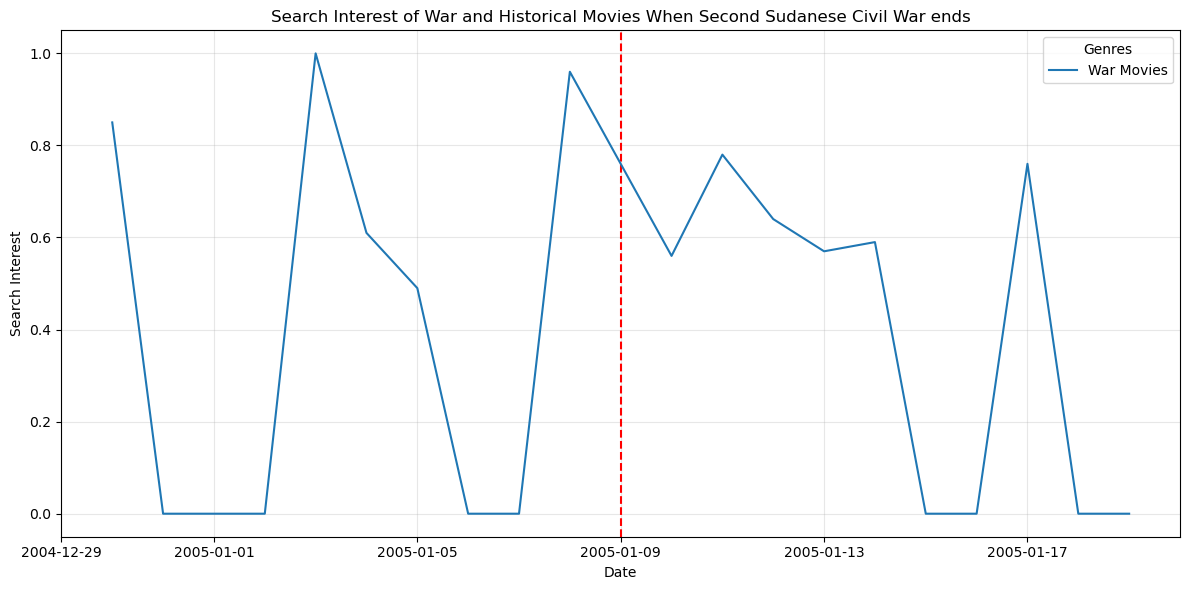

Fetching for: The Provisional Irish Republican Army ends its military campaign in Northern Ireland.
Attempt 1 failed: HTTPSConnectionPool(host='realtime.oxylabs.io', port=443): Read timed out. (read timeout=100)
Retrying...
Attempt 2 failed: HTTPSConnectionPool(host='realtime.oxylabs.io', port=443): Read timed out. (read timeout=100)
Retrying...
Attempt 3 failed: HTTPSConnectionPool(host='realtime.oxylabs.io', port=443): Read timed out. (read timeout=100)
Retrying...
[{'time': 'Jul 18, 2005', 'value': 75}, {'time': 'Jul 19, 2005', 'value': 66}, {'time': 'Jul 20, 2005', 'value': 93}, {'time': 'Jul 21, 2005', 'value': 64}, {'time': 'Jul 22, 2005', 'value': 51}, {'time': 'Jul 23, 2005', 'value': 88}, {'time': 'Jul 24, 2005', 'value': 76}, {'time': 'Jul 25, 2005', 'value': 43}, {'time': 'Jul 26, 2005', 'value': 0}, {'time': 'Jul 27, 2005', 'value': 58}, {'time': 'Jul 28, 2005', 'value': 47}, {'time': 'Jul 29, 2005', 'value': 49}, {'time': 'Jul 30, 2005', 'value': 57}, {'time': 'Jul 31, 200

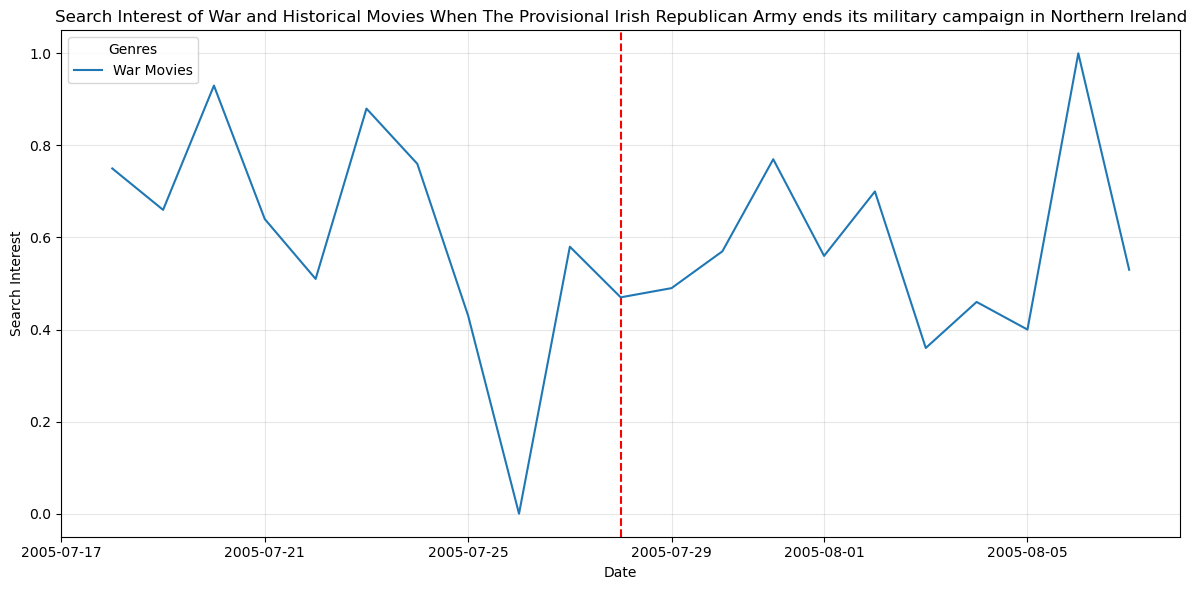

Fetching for: 2006 al-Askari mosque bombing turns the escalation of sectarian violence in Iraq into a full-scale war (the Iraqi Civil War of 2006-2008 ).
[{'time': 'Feb 12, 2006', 'value': 95}, {'time': 'Feb 13, 2006', 'value': 65}, {'time': 'Feb 14, 2006', 'value': 62}, {'time': 'Feb 15, 2006', 'value': 50}, {'time': 'Feb 16, 2006', 'value': 69}, {'time': 'Feb 17, 2006', 'value': 58}, {'time': 'Feb 18, 2006', 'value': 71}, {'time': 'Feb 19, 2006', 'value': 84}, {'time': 'Feb 20, 2006', 'value': 81}, {'time': 'Feb 21, 2006', 'value': 52}, {'time': 'Feb 22, 2006', 'value': 76}, {'time': 'Feb 23, 2006', 'value': 77}, {'time': 'Feb 24, 2006', 'value': 50}, {'time': 'Feb 25, 2006', 'value': 100}, {'time': 'Feb 26, 2006', 'value': 0}, {'time': 'Feb 27, 2006', 'value': 45}, {'time': 'Feb 28, 2006', 'value': 65}, {'time': 'Mar 1, 2006', 'value': 54}, {'time': 'Mar 2, 2006', 'value': 82}, {'time': 'Mar 3, 2006', 'value': 70}, {'time': 'Mar 4, 2006', 'value': 97}]
           time  value
0  Feb 

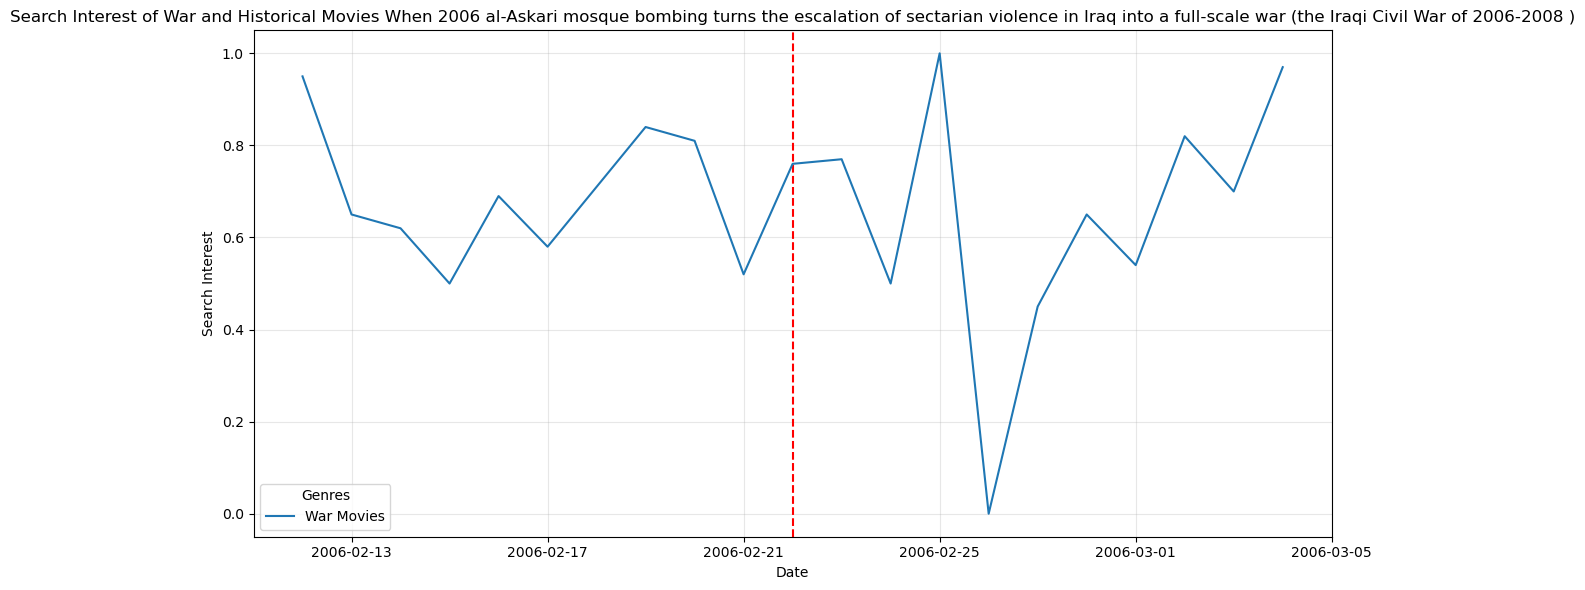

Fetching for: First Ivorian Civil War ends.
[{'time': 'Feb 22, 2007', 'value': 72}, {'time': 'Feb 23, 2007', 'value': 54}, {'time': 'Feb 24, 2007', 'value': 86}, {'time': 'Feb 25, 2007', 'value': 75}, {'time': 'Feb 26, 2007', 'value': 66}, {'time': 'Feb 27, 2007', 'value': 64}, {'time': 'Feb 28, 2007', 'value': 58}, {'time': 'Mar 1, 2007', 'value': 69}, {'time': 'Mar 2, 2007', 'value': 62}, {'time': 'Mar 3, 2007', 'value': 75}, {'time': 'Mar 4, 2007', 'value': 97}, {'time': 'Mar 5, 2007', 'value': 68}, {'time': 'Mar 6, 2007', 'value': 78}, {'time': 'Mar 7, 2007', 'value': 73}, {'time': 'Mar 8, 2007', 'value': 58}, {'time': 'Mar 9, 2007', 'value': 78}, {'time': 'Mar 10, 2007', 'value': 100}, {'time': 'Mar 11, 2007', 'value': 89}, {'time': 'Mar 12, 2007', 'value': 57}, {'time': 'Mar 13, 2007', 'value': 64}, {'time': 'Mar 14, 2007', 'value': 83}]
           time  value
0  Feb 22, 2007     72
1  Feb 23, 2007     54
2  Feb 24, 2007     86
3  Feb 25, 2007     75
4  Feb 26, 2007     66


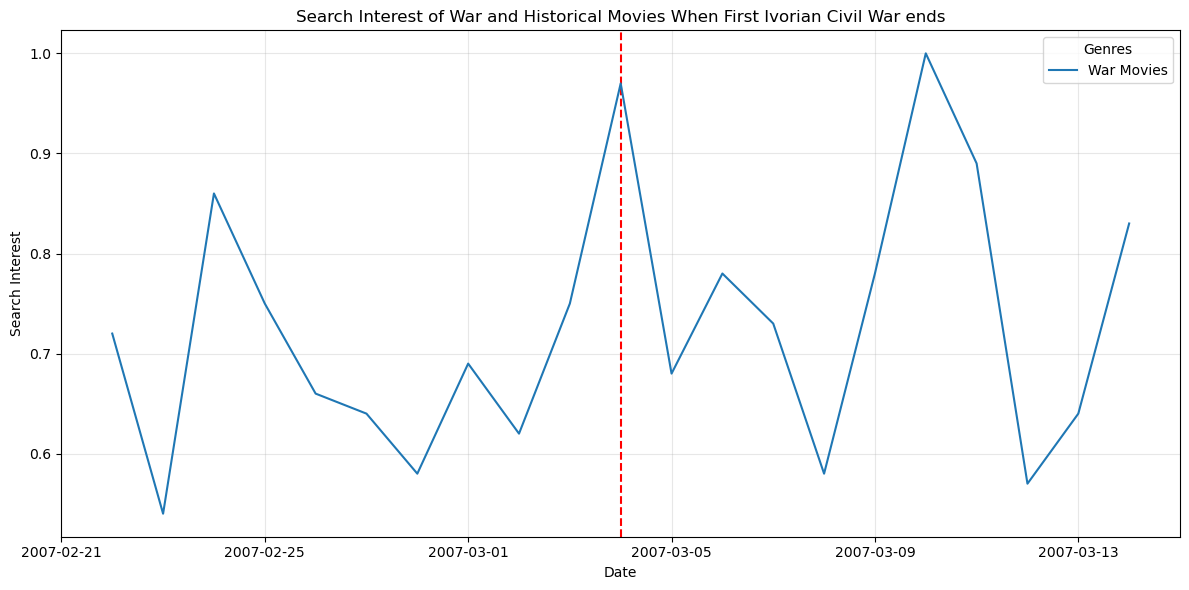

Fetching for: Fatah-Hamas conflict : The Battle of Gaza (2007) leads to Hamas taking control of the Gaza strip.
[{'time': 'May 31, 2007', 'value': 63}, {'time': 'Jun 1, 2007', 'value': 71}, {'time': 'Jun 2, 2007', 'value': 95}, {'time': 'Jun 3, 2007', 'value': 98}, {'time': 'Jun 4, 2007', 'value': 53}, {'time': 'Jun 5, 2007', 'value': 72}, {'time': 'Jun 6, 2007', 'value': 49}, {'time': 'Jun 7, 2007', 'value': 73}, {'time': 'Jun 8, 2007', 'value': 65}, {'time': 'Jun 9, 2007', 'value': 85}, {'time': 'Jun 10, 2007', 'value': 100}, {'time': 'Jun 11, 2007', 'value': 59}, {'time': 'Jun 12, 2007', 'value': 73}, {'time': 'Jun 13, 2007', 'value': 50}, {'time': 'Jun 14, 2007', 'value': 65}, {'time': 'Jun 15, 2007', 'value': 83}, {'time': 'Jun 16, 2007', 'value': 58}, {'time': 'Jun 17, 2007', 'value': 80}, {'time': 'Jun 18, 2007', 'value': 59}, {'time': 'Jun 19, 2007', 'value': 65}, {'time': 'Jun 20, 2007', 'value': 61}]
           time  value
0  May 31, 2007     63
1   Jun 1, 2007     71
2   Jun

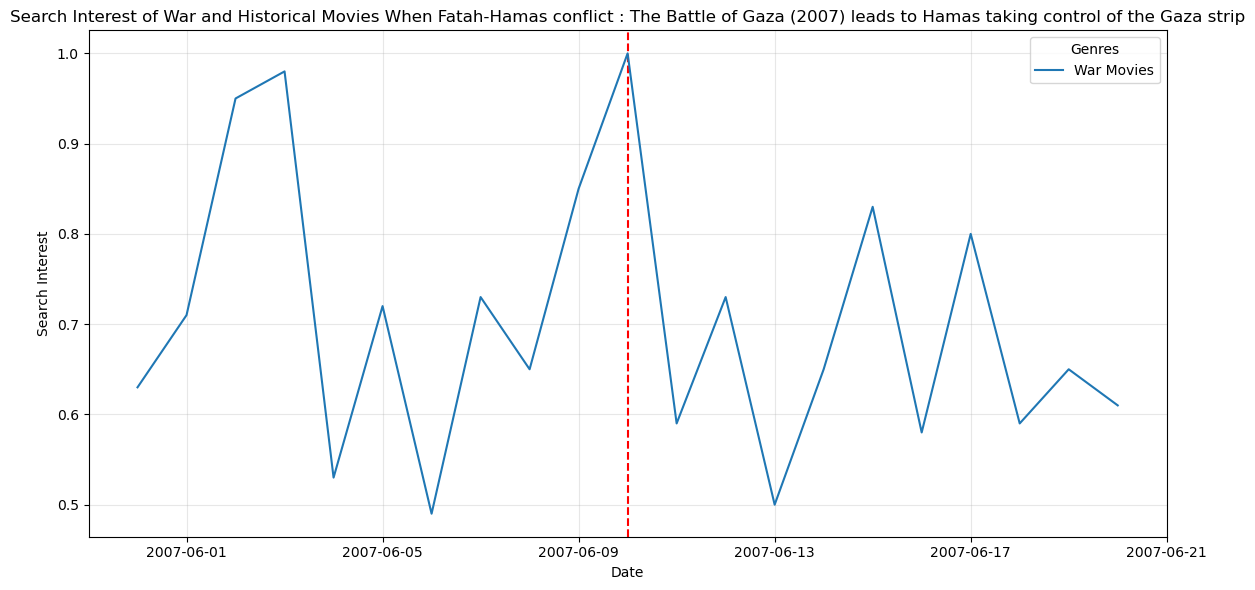

Fetching for: North Korea  shells the island of Yeonpyeong .
[{'time': 'Nov 13, 2010', 'value': 99}, {'time': 'Nov 14, 2010', 'value': 93}, {'time': 'Nov 15, 2010', 'value': 67}, {'time': 'Nov 16, 2010', 'value': 59}, {'time': 'Nov 17, 2010', 'value': 68}, {'time': 'Nov 18, 2010', 'value': 65}, {'time': 'Nov 19, 2010', 'value': 72}, {'time': 'Nov 20, 2010', 'value': 92}, {'time': 'Nov 21, 2010', 'value': 93}, {'time': 'Nov 22, 2010', 'value': 68}, {'time': 'Nov 23, 2010', 'value': 65}, {'time': 'Nov 24, 2010', 'value': 67}, {'time': 'Nov 25, 2010', 'value': 69}, {'time': 'Nov 26, 2010', 'value': 69}, {'time': 'Nov 27, 2010', 'value': 100}, {'time': 'Nov 28, 2010', 'value': 88}, {'time': 'Nov 29, 2010', 'value': 61}, {'time': 'Nov 30, 2010', 'value': 65}, {'time': 'Dec 1, 2010', 'value': 63}, {'time': 'Dec 2, 2010', 'value': 62}, {'time': 'Dec 3, 2010', 'value': 64}]
           time  value
0  Nov 13, 2010     99
1  Nov 14, 2010     93
2  Nov 15, 2010     67
3  Nov 16, 2010     59
4  Nov

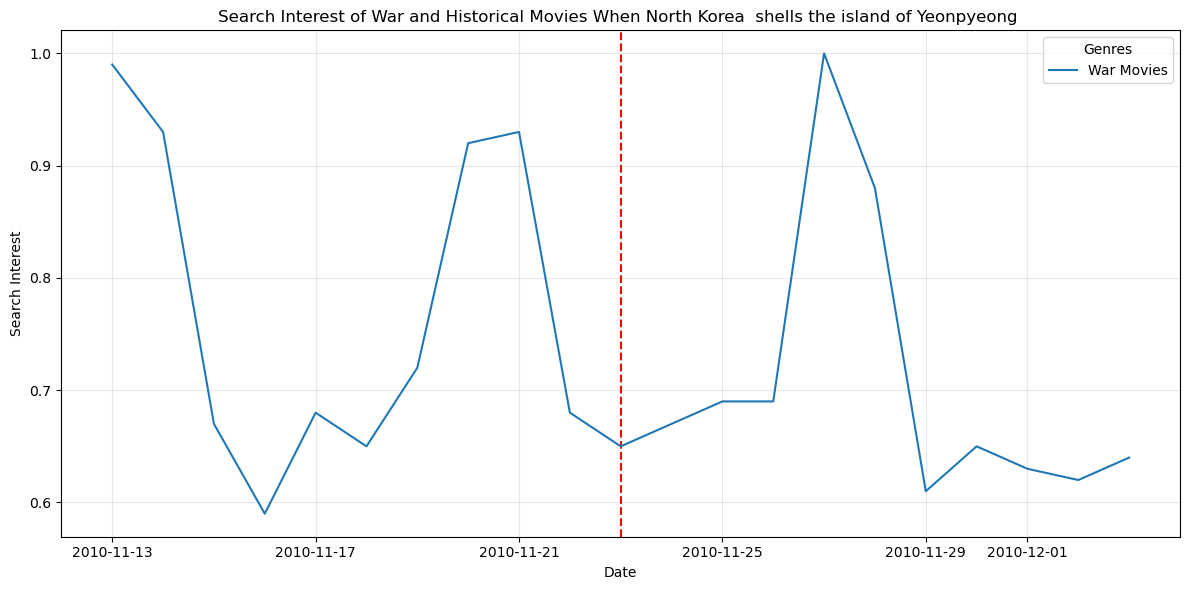

Fetching for: Osama bin Laden is shot dead by United States Navy SEALs in Pakistan .
[{'time': 'Apr 22, 2011', 'value': 78}, {'time': 'Apr 23, 2011', 'value': 92}, {'time': 'Apr 24, 2011', 'value': 92}, {'time': 'Apr 25, 2011', 'value': 83}, {'time': 'Apr 26, 2011', 'value': 57}, {'time': 'Apr 27, 2011', 'value': 59}, {'time': 'Apr 28, 2011', 'value': 57}, {'time': 'Apr 29, 2011', 'value': 65}, {'time': 'Apr 30, 2011', 'value': 73}, {'time': 'May 1, 2011', 'value': 85}, {'time': 'May 2, 2011', 'value': 71}, {'time': 'May 3, 2011', 'value': 69}, {'time': 'May 4, 2011', 'value': 58}, {'time': 'May 5, 2011', 'value': 58}, {'time': 'May 6, 2011', 'value': 73}, {'time': 'May 7, 2011', 'value': 87}, {'time': 'May 8, 2011', 'value': 100}, {'time': 'May 9, 2011', 'value': 63}, {'time': 'May 10, 2011', 'value': 61}, {'time': 'May 11, 2011', 'value': 68}, {'time': 'May 12, 2011', 'value': 52}]
           time  value
0  Apr 22, 2011     78
1  Apr 23, 2011     92
2  Apr 24, 2011     92
3  Apr 25, 

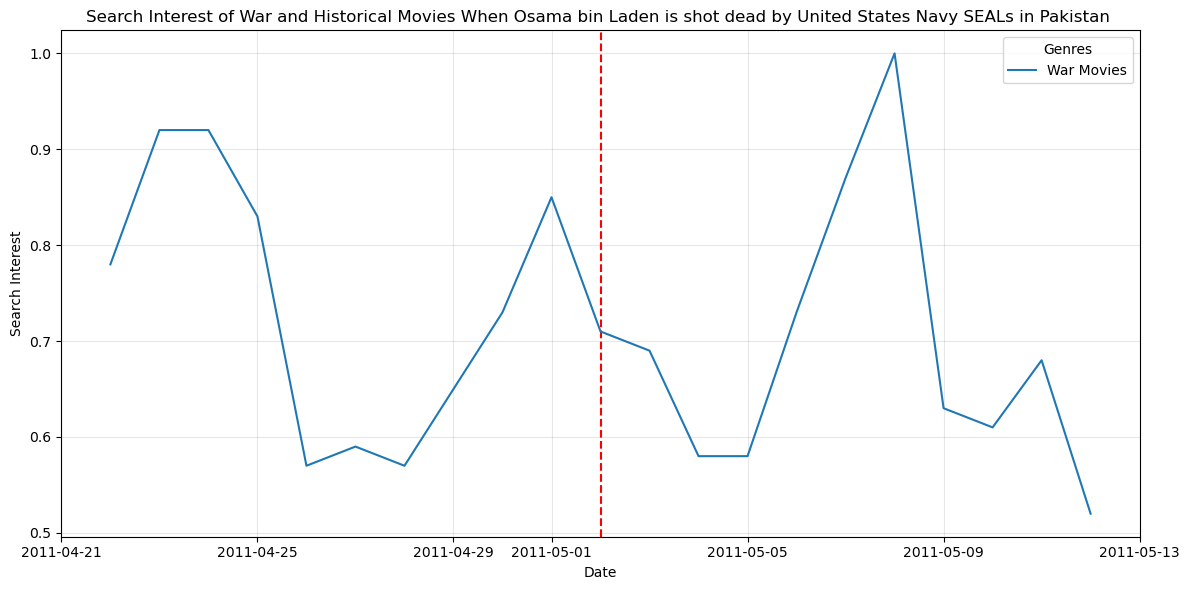

Fetching for: Muammar Gaddafi is captured and killed during the Battle of Sirte .
[{'time': 'Oct 10, 2011', 'value': 76}, {'time': 'Oct 11, 2011', 'value': 67}, {'time': 'Oct 12, 2011', 'value': 66}, {'time': 'Oct 13, 2011', 'value': 63}, {'time': 'Oct 14, 2011', 'value': 75}, {'time': 'Oct 15, 2011', 'value': 88}, {'time': 'Oct 16, 2011', 'value': 98}, {'time': 'Oct 17, 2011', 'value': 71}, {'time': 'Oct 18, 2011', 'value': 65}, {'time': 'Oct 19, 2011', 'value': 69}, {'time': 'Oct 20, 2011', 'value': 70}, {'time': 'Oct 21, 2011', 'value': 74}, {'time': 'Oct 22, 2011', 'value': 100}, {'time': 'Oct 23, 2011', 'value': 93}, {'time': 'Oct 24, 2011', 'value': 61}, {'time': 'Oct 25, 2011', 'value': 65}, {'time': 'Oct 26, 2011', 'value': 75}, {'time': 'Oct 27, 2011', 'value': 74}, {'time': 'Oct 28, 2011', 'value': 69}, {'time': 'Oct 29, 2011', 'value': 91}, {'time': 'Oct 30, 2011', 'value': 97}]
           time  value
0  Oct 10, 2011     76
1  Oct 11, 2011     67
2  Oct 12, 2011     66
3  Oc

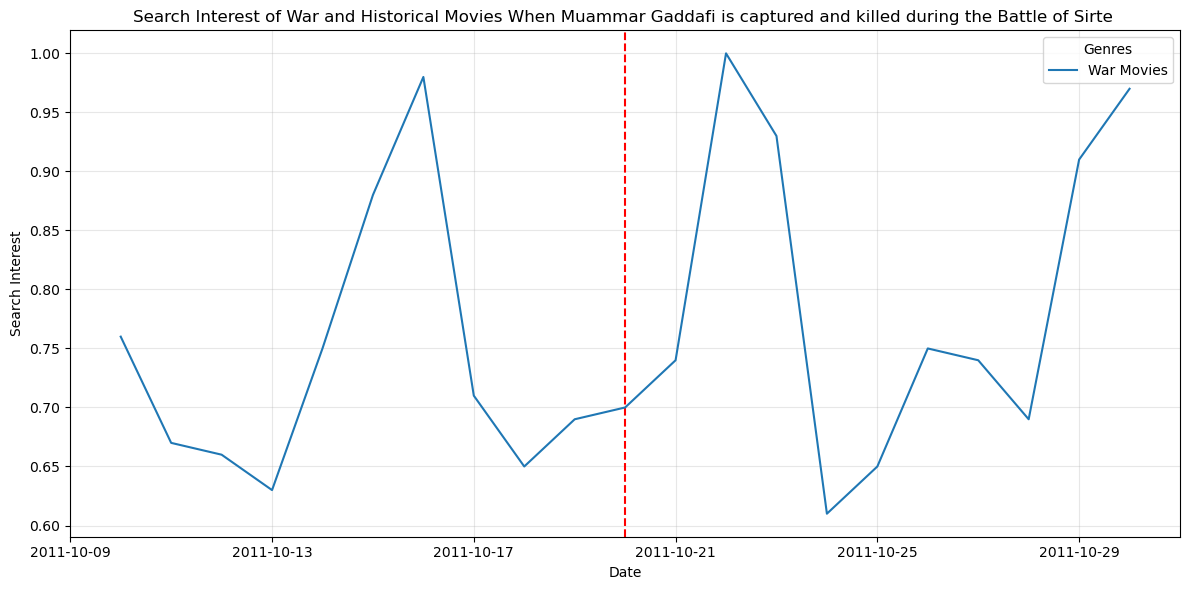

In [33]:
# Fetch the interest for the war and historical movies around the wars
for i, war in wars_filtered.iterrows():
    date = war['date']
    description = war['description']

    # Define the plot
    plt.figure(figsize=(12, 6))
    plt.title(f'Search Interest of War and Historical Movies When {description.split(".")[0]}')
    plt.xlabel('Date')
    plt.ylabel('Search Interest')

    # Fetch the search interest around the data
    print(f"Fetching for: {description}")
    trend = gt.query_interest_around_date("war movies", date)
    
    # Mark the date of event
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', linewidth=1.5)

    # Plot the trend value over time
    plt.plot(trend['date'], trend['value'], label="War Movies")

    # Add labels and legend
    plt.legend(title='Genres')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()